In [1]:
# analysis
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.integrate import odeint

# plotting
import cmocean.cm as cm
from matplotlib import rc, rcParams
rc('font', family = 'serif')
rcParams["text.usetex"]=True
rc('xtick', labelsize=28) 
rc('ytick', labelsize=28) 
rc('axes', labelsize=28)


#### This notebook can be used to reproduce all panels of Figure 3.
author: Ruth Moorman, April 2023, rmoorman@caltech.edu

# Defining the Ice Front Overturning Model

Our model is a simple system of two coupled differential equations,
$$\frac{\mathrm{d}h_\mathrm{WW}}{\mathrm{d}t} = \frac{1}{L}\Big[\alpha (H-h_\mathrm{WW})+\frac{\kappa_P L}{h_\mathrm{WW}}-\Psi_\mathrm{in}\Big],$$

$$\frac{\mathrm{d}b_\mathrm{WW}}{\mathrm{d}t} = \frac{1}{L}\Big[\frac{\alpha(H-h_\mathrm{WW})b_\mathrm{melt}}{h_\mathrm{WW}}-\frac{\Psi_\mathrm{in} b_\mathrm{WW}}{h_\mathrm{WW}}\Big]+\frac{1}{h_\mathrm{WW}}\Big[F_\mathrm{surf}-\frac{\kappa_P b_\mathrm{WW}}{h_\mathrm{WW}}\Big],$$
where,
$$    \kappa_P(b_\mathrm{WW}) = \frac{ \kappa_\mathrm{conv}-\kappa_\mathrm{diff}}{2}\Big(1-\tanh{\big(\phi(b_\mathrm{WW}-b_\mathrm{crit})\big)}\Big)+\kappa_\mathrm{diff}.$$


note: $h_\mathrm{WW}$ in these ntoebooks is $h$ in the manuscript, $b_\mathrm{WW}$ in these ntoebooks is $\Delta b$ in the manuscript

In [2]:
def ODE(y,t):
    κ_P    = (κ_conv-κ_diff)/2 * (1-np.tanh(ϕ*(y[1]-b_crit))) + κ_diff
    h_WW   = α*(H-y[0])/L + κ_P/y[0] - Ψ_in/L
    b_WW   = α*(H-y[0])*b_melt/(L*y[0]) - Ψ_in*y[1]/(L*y[0]) + F_surf/y[0] - κ_P*y[1]/(y[0]**2)
    return [h_WW,b_WW]

In [3]:
def initialize_ODE(h_init,b_init,N, Δt, Ψin, Fsurf, parameters , percentage = 0.005):
    # default params Dict
    global params
    params = parameters
    global Ψ_in; Ψ_in=Ψin
    global F_surf; F_surf=Fsurf
    
   # time dimension
    Δts = Δt*60*60*24 # convert to seconds
    t_init = np.arange(0, N*365*24*60*60, Δts)
    # odeint ODE integration
    soln = odeint(ODE, [h_init,b_init], t_init)
    # extract variables
    h_WW = soln[:,0]; b_WW = soln[:,1]
    # convergence test (last 10 timesteps have a std that is less than percentage% of mean)
    if np.abs(np.std(b_WW[-10:])/np.mean(b_WW[-10:])*100)>percentage:
        print('Convergence Failure')
    elif np.abs(np.std(h_WW[-10:])/np.mean(h_WW[-10:])*100)>percentage:
        print('Convergence Failure')
    return [h_WW,b_WW, t_init/(24*60*60), params]

# Figure 3 (a)

note: arrows added manually later

In this first panel we show hysteresis over the range of $F_\mathrm{surf}$ values simulated in WAIS 1080 and the mean $\Psi_\mathrm{in}$ value in WAIS 1080 for out parameter value choices. Note the sensitivity to these parameter value choices is explored in a separate notebook.

In [4]:
forcings = xr.open_dataset('WAIS1080_forcings.nc')

In [5]:
Ψin_WAIS1080 = forcings.Psiin
Fsurf_WAIS1080 = forcings.Fsurf
translation = 1e6/(55*1e3) 

In [6]:
print('mean and range Fsurf (m2/s3):',Fsurf_WAIS1080.mean().values,[Fsurf_WAIS1080.min().values*1,Fsurf_WAIS1080.max().values*1])
print('mean and range Ψin (Sv):',Ψin_WAIS1080.mean().values,[Ψin_WAIS1080.min().values*1,Ψin_WAIS1080.max().values*1])
print('mean and range Ψin (model m2/s):',Ψin_WAIS1080.mean().values*translation,[Ψin_WAIS1080.min().values*translation,Ψin_WAIS1080.max().values*translation])


mean and range Fsurf (m2/s3): -2.650803424903477e-08 [-1.6506006161017006e-07, 5.3327103380551477e-08]
mean and range Ψin (Sv): 0.06163183294540644 [0.0, 0.29414690325927734]
mean and range Ψin (model m2/s): 1.1205787808255716 [0.0, 5.3481255138050425]


In [7]:
# parameter values 
params = {"L":0.5e5, "H":700, "κ_diff":1e-4, "κ_conv":1e-2, "b_melt":0.0067, "b_crit":5e-4, "ϕ":5e4, "α":0.0021}
L=params["L"];H = params["H"]; κ_diff = params["κ_diff"];κ_conv = params["κ_conv"];b_melt = params["b_melt"];b_crit = params["b_crit"];ϕ = params["ϕ"];α = params["α"];
N           = 200
Fsurf_min   = -1.65e-7
Fsurf_max   = 5e-8 ## Fsurf range from WAIS1080 (small box)
Ψin         = 1.1 ## mean value from WAIS1080 (small box) is 1.120...
Fsurf_array_forwards = np.linspace(Fsurf_min,Fsurf_max,N)
Fsurf_array_backwards = np.flip(Fsurf_array_forwards)
hWW_forward = np.zeros(N); bWW_forward = np.zeros(N)
hWW_backward = np.zeros(N); bWW_backward = np.zeros(N)


# start at the negative end and increase surface buoyancy forcing
[hWW_cool_init,bWW_cool_init, t_init, params]   = initialize_ODE(h_init=H/2,b_init=-b_melt, N=5, Δt=1, Ψin=Ψin, Fsurf=Fsurf_array_forwards[0], parameters = params, percentage = 0.05)
hWW_old = hWW_cool_init[-1];bWW_old = bWW_cool_init[-1]
hWW_forward[0] = hWW_old; bWW_forward[0] = bWW_old
for i in range(1,N):
    [hWW_new,bWW_new, t_init, params] = initialize_ODE(h_init=hWW_old,b_init=bWW_old, N=3, Δt=1, Ψin=Ψin, Fsurf=Fsurf_array_forwards[i], parameters = params, percentage = 0.05)
    hWW_old = hWW_new[-1]; bWW_old = bWW_new[-1]
    hWW_forward[i] = hWW_old; bWW_forward[i] = bWW_old

    
# start at the positive end and decrease surface buoyancy forcing
[hWW_warm_init,bWW_warm_init, t_init, params]     = initialize_ODE(h_init=H/2,b_init=b_melt, N=5, Δt=1, Ψin=Ψin, Fsurf=Fsurf_array_backwards[0],  parameters = params, percentage = 0.05)
hWW_old = hWW_warm_init[-1]; bWW_old = bWW_warm_init[-1]
hWW_backward[0] = hWW_old; bWW_backward[0] = bWW_old
for i in range(1,N):
    [hWW_new,bWW_new, t_init, params] = initialize_ODE(h_init=hWW_old,b_init=bWW_old, N=3, Δt=1, Ψin=Ψin, Fsurf= Fsurf_array_backwards[i], parameters = params, percentage = 0.05)
    hWW_old = hWW_new[-1]; bWW_old = bWW_new[-1]
    hWW_backward[i] = hWW_old; bWW_backward[i] = bWW_old
    

Convergence Failure


note: tend to get some convergence failure around the regime transition

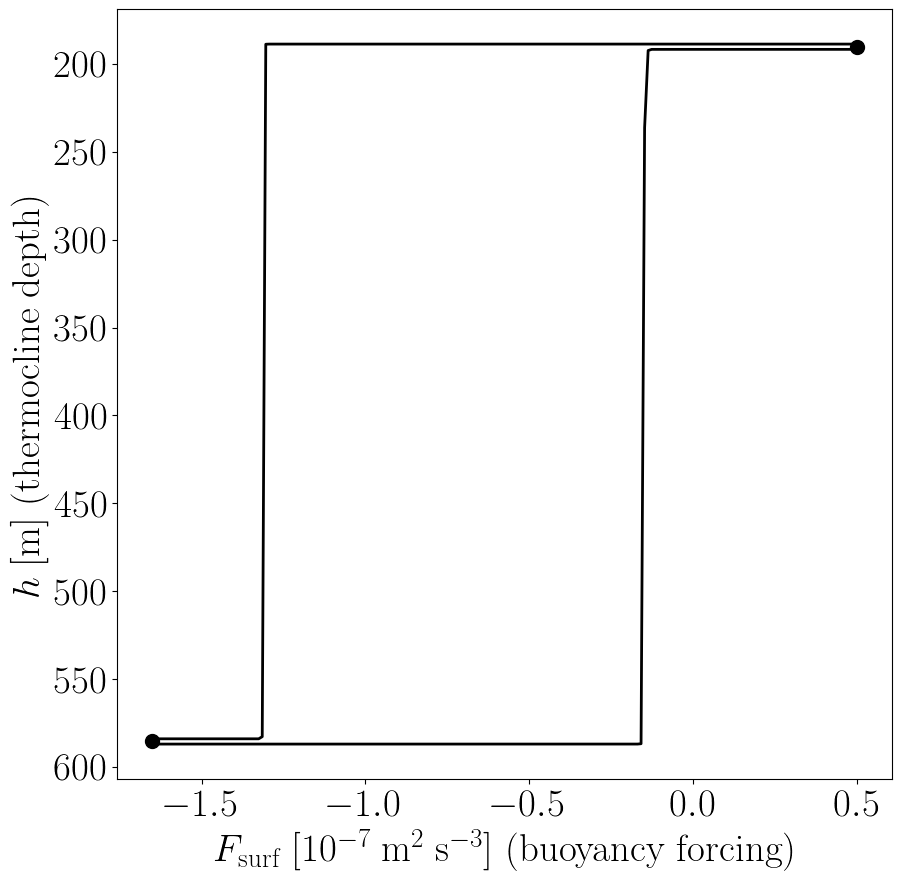

In [8]:
fig, (ax) = plt.subplots(1, 1, figsize=(10,10))
ax.plot(Fsurf_array_forwards*1e7,hWW_forward+3, 'k', linewidth=2)
ax.plot(Fsurf_array_backwards*1e7,hWW_backward, 'k', linewidth=2)
ax.plot(Fsurf_array_forwards[0]*1e7,hWW_forward[0]+1.5, 'ko', markersize=10)
ax.plot(Fsurf_array_backwards[0]*1e7,hWW_backward[0]+1.5, 'ko', markersize=10)
ax.set_xlabel(r'$F_\mathrm{surf}\;[10^{-7}\;\mathrm{m}^2\;\mathrm{s}^{-3}]$ (buoyancy forcing)',fontsize=28)
ax.set_ylabel(r'$h \; [\mathrm{m}] $ (thermocline depth)',fontsize=28)
ax.invert_yaxis()
plt.savefig('Figure3_a.png')

plt.show()

# Figure 3 (b-e)

In [9]:
def initialize_ODE_brute(h_init,b_init):
    n_years = 10
    Δt = 24*60*60 # 24h timestep
    t_init = np.arange(0, n_years*365*24*60*60, Δt)
    soln = odeint(ODE, [h_init,b_init], t_init)
    h = soln[:,0]; b = soln[:,1]
    return [h,b]

In [10]:
def phase_space_generator(Ψin_min, Ψin_max, Fsurf_min,Fsurf_max, n, params):
    L=params["L"];H = params["H"]; κ_diff = params["κ_diff"];κ_conv = params["κ_conv"];b_melt = params["b_melt"];b_crit = params["b_crit"];ϕ = params["ϕ"];α = params["α"];
    Ψin          = np.linspace(Ψin_min,Ψin_max,n)
    Fsurf        = np.linspace(Fsurf_min,Fsurf_max,n)
    REGIME       = xr.DataArray(np.zeros((n,n)), coords = [Fsurf,Ψin], dims=['Fsurf','Ψin'], attrs={'description':'1: diffusive solution only, 2:convective solution only, 3: diffusive and convective solutions'})
    h_diffusive  = xr.DataArray(np.zeros((n,n)), coords = [Fsurf,Ψin], dims=['Fsurf','Ψin'], attrs={'description': 'steady state h_WW associated with κ_diff'})
    h_convective = xr.DataArray(np.zeros((n,n)), coords = [Fsurf,Ψin], dims=['Fsurf','Ψin'], attrs={'description': 'steady state h_WW associated with κ_conv'})
    b_diffusive  = xr.DataArray(np.zeros((n,n)), coords = [Fsurf,Ψin], dims=['Fsurf','Ψin'], attrs={'description': 'steady state b_WW associated with κ_diff'})
    b_convective = xr.DataArray(np.zeros((n,n)), coords = [Fsurf,Ψin], dims=['Fsurf','Ψin'], attrs={'description': 'steady state b_WW associated with κ_conv'})
    h_diffusive[:,:] = np.nan;h_convective[:,:] = np.nan;b_diffusive[:,:] = np.nan;b_convective[:,:] = np.nan

    count=0
    convergence_issue_count = 0
    for i in range(n):
        global Ψ_in; Ψ_in=Ψin[i]; #print(i,Ψ_in)
        for j in range(n):
            global F_surf; F_surf=Fsurf[j]

            ## STEP ODE FORWARD IN TIME 10 YEARS (BRUTE FORCE EQUILIBRATION)
            h_init = 350; b_init = b_melt; h_thresh=1e-3; b_thresh=1e-6
            [h_buoy,b_buoy] = initialize_ODE_brute(h_init,b_init)

            h_init = 350; b_init = -b_melt; h_thresh=1e-3; b_thresh=1e-6
            [h_dense,b_dense] = initialize_ODE_brute(h_init,b_init)
            
            ## CATEGORIZE OUTPUT INTO (1) THERMOCLINE CONVERGENCE ISSUE, (2) BUOYANCY CONVERGENCE ISSUE, (3) BISTABLE (DISTINCT SOLUTIONS), (4) DIFFUSIVE ONLY (1 SOLUTION WITH BUOYANCY ABOVE BCRIT), (5) CONVECTIVE ONLY (1 SOLUTION WITH BUOYANCY BELOW BCRIT), (6) ALL OTHER ISSUES

            if np.abs(h_buoy[-1]-h_buoy[-2])>h_thresh:
                REGIME[j,i]  = np.nan
                h_diffusive[j,i]  = np.nan;h_convective[j,i] = np.nan;b_diffusive[j,i]  = np.nan;b_convective[j,i] = np.nan
                convergence_issue_count=convergence_issue_count+1;
            elif np.abs(b_buoy[-1]-b_buoy[-2])>b_thresh:
                REGIME[j,i]  = np.nan
                h_diffusive[j,i]  = np.nan;h_convective[j,i] = np.nan;b_diffusive[j,i]  = np.nan;b_convective[j,i] = np.nan
                convergence_issue_count=convergence_issue_count+1;
            elif np.round(h_buoy[-1]) != np.round(h_dense[-1]):
                REGIME[j,i]  = 3 # bistable
                h_diffusive[j,i]  = h_buoy[-1];h_convective[j,i] = h_dense[-1];b_diffusive[j,i]  = b_buoy[-1];b_convective[j,i] = b_dense[-1]
            elif b_buoy[-1] > b_crit:
                REGIME[j,i]  = 1 # diffusive only
                h_diffusive[j,i]  = h_buoy[-1];h_convective[j,i] = np.nan;b_diffusive[j,i]  = b_buoy[-1];b_convective[j,i] = np.nan
            elif b_dense[-1] < b_crit:
                REGIME[j,i]  = 2 # convective only
                h_diffusive[j,i]  = np.nan;h_convective[j,i] = h_dense[-1];b_diffusive[j,i]  = np.nan;b_convective[j,i] = b_dense[-1]    
            else:
                REGIME[j,i]  = np.nan # an issue
                h_diffusive[j,i]  = np.nan;h_convective[j,i] = np.nan;b_diffusive[j,i]  = np.nan;b_convective[j,i] = np.nan    
    ds = xr.Dataset({'REGIME':REGIME, 'h_diff':h_diffusive, 'h_conv':h_convective, 'b_diff':b_diffusive, 'b_conv':b_convective})
    print(convergence_issue_count/(n*n)*100)
    return ds

In [11]:
print('range Fsurf (m2/s3):',[Fsurf_WAIS1080.min().values,Fsurf_WAIS1080.max().values])
print('range Ψin (Sv):',[Ψin_WAIS1080.min().values,Ψin_WAIS1080.max().values])
print('range Ψin (m2/s):',[Ψin_WAIS1080.min().values*translation,Ψin_WAIS1080.max().values*translation])


range Fsurf (m2/s3): [array(-1.65060062e-07), array(5.33271034e-08)]
range Ψin (Sv): [array(0.), array(0.2941469)]
range Ψin (m2/s): [0.0, 5.3481255138050425]


Feel free to uncomment and run the below code, however note that it can take a while to run so you can also reload the saved .nc file.

```
%%time
# takes about 15 min
phase_space = phase_space_generator(0, 0.3*translation, -2e-7,6e-8, 400, params) # make sure to expand beyond model values
phase_space.to_netcdf('phase_space.nc')
```

```
## there were some unconverged regions with pretty obvious values so there were interpolated (plus some extrapolation to the upper right corner of the diffusive bWW plot purely for visualization purposes - this region is pure black in the figure due to contour convergence)
h_conv = phase_space.h_conv
h_conv[-1,0:13]=h_conv[-90,0:13].values
h_conv_ex = h_conv.interpolate_na(dim='Fsurf', method='linear')
b_conv = phase_space.b_conv
b_conv[-1,0:13] = np.linspace(-1.1e-3,0.00045,13)
b_conv_ex = b_conv.interpolate_na(dim='Fsurf', method='linear')
h_diff = phase_space.h_diff
# h_diff_ex = h_diff
h_diff[-1:,0:27]=h_diff[-90,0:27].values
h_diff_ex = h_diff.interpolate_na(dim='Fsurf', method='linear')
b_diff = phase_space.b_diff
# b_diff_ex = b_diff
b_diff[-1,0:13] = np.linspace(0.03,0.021429,13)
b_diff_ex = b_diff.interpolate_na(dim='Fsurf', method='linear')
h_diff_ex=h_diff_ex.where(b_diff_ex>b_crit)
b_diff_ex=b_diff_ex.where(b_diff_ex>b_crit)
regime = (h_diff_ex*0+1).fillna(0) + (h_conv_ex*0+2).fillna(0)

phase_space_cleaned = xr.Dataset({'REGIME':regime, 'h_conv':h_conv_ex, 'h_diff':h_diff_ex, 'b_conv':b_conv_ex, 'b_diff':b_diff_ex})
phase_space_cleaned.to_netcdf('phase_space_cleaned.nc')
```

In [12]:
phase_space = xr.open_dataset('phase_space.nc')
phase_space_cleaned = xr.open_dataset('phase_space_cleaned.nc')

In [13]:
rc('font', family = 'serif')
rcParams["text.usetex"]=True
rc('xtick', labelsize=18) 
rc('ytick', labelsize=18) 
rc('axes', labelsize=18)

In [14]:
Ψin_WAIS1080_clim = Ψin_WAIS1080.groupby('time.month').mean()
Fsurf_WAIS1080_clim = Fsurf_WAIS1080.groupby('time.month').mean()
Ψin_WAIS1080_mean = Ψin_WAIS1080.mean('time').values*1
Fsurf_WAIS1080_mean = Fsurf_WAIS1080.mean('time').values*1

In [15]:
def labeled_contours(ax,field,levels,strs,manuals, color='k',f=17):
    contours = ax.contour(Ψin,Fsurf*1e7 ,field, levels=levels, colors=[color])
    fmt = {}
    for l, s in zip(contours.levels, strs):
        fmt[l] = s
    ax.clabel(contours, contours.levels, fmt=fmt, inline=True, fontsize=f,rightside_up=False, manual =manuals)


In [16]:
Ψin_WAIS1080_mean

0.06163183294540644

In [17]:
Fsurf_WAIS1080_mean

-2.650803424903477e-08

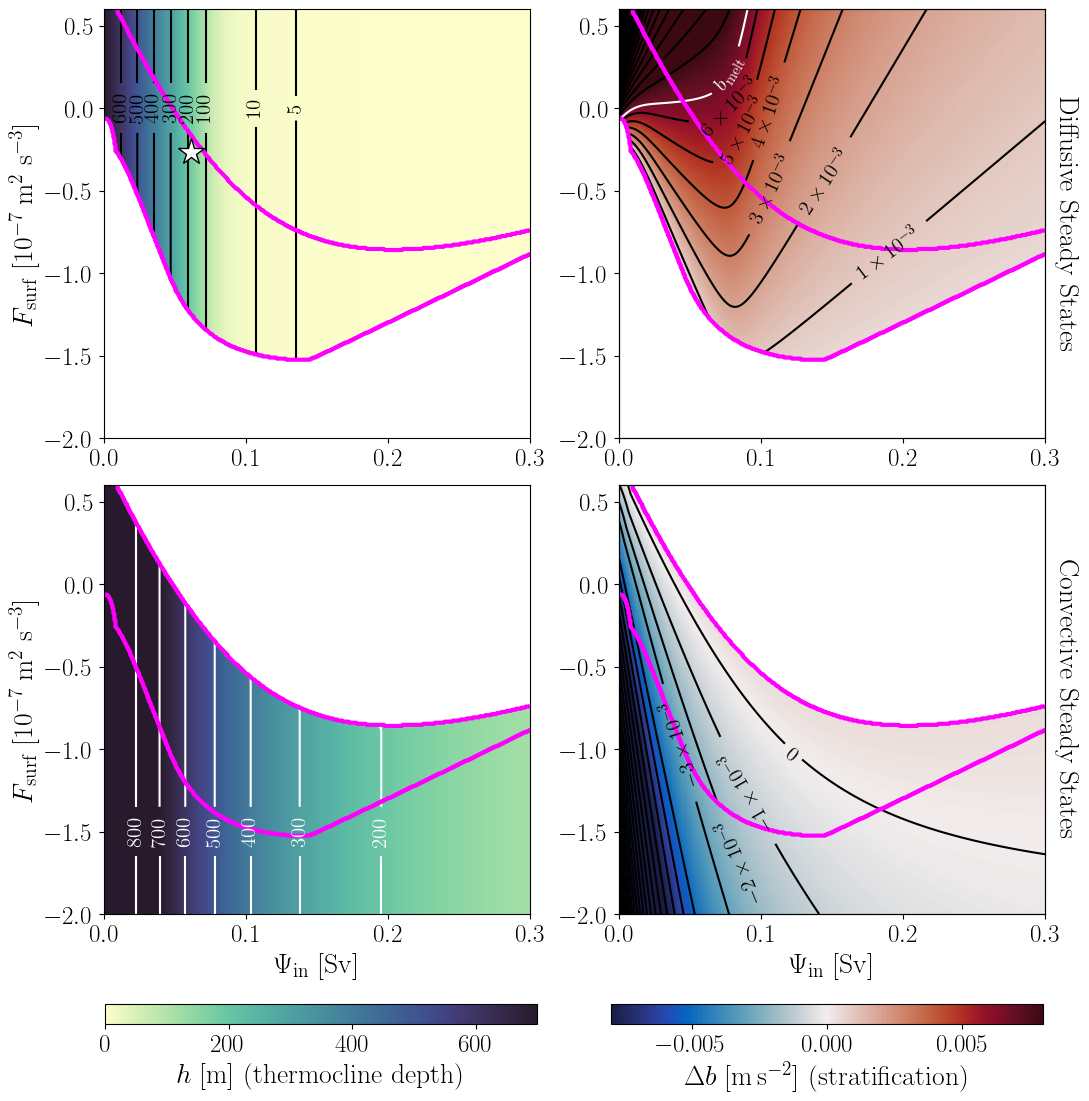

In [27]:
fig, ((ax,ax1),(ax2,ax3)) = plt.subplots(2, 2, figsize=(11,10))

ds = phase_space_cleaned 
f=20

REGIME = ds.REGIME.load()
h_diffusive = ds.h_diff.load()
h_convective = ds.h_conv.load()
b_diffusive = ds.b_diff.load()
b_convective = ds.b_conv.load()
translation = 1e6/(55*1e3)
Ψin = ds.Ψin.load()/translation ## conversion step!!
Fsurf = ds.Fsurf.load()


l1 = [5,10,100,200,300,400,500,600]
strs1 = [ r'$5$',r'$10$',r'$100$', r'$200$', r'$300$',r'$400$',r'$500$', '600']
manual_locations1 = [(0.15,0),(0.12,0),(0.08,0),(0.07,0),(0.06,0),(0.05,0),(0.03,0),(0.01,0)]

l2 = np.arange(10,70,10)*1e-4
strs2 = [r'$1\times 10^{-3}$', r'$2\times 10^{-3}$', r'$3\times 10^{-3}$', r'$4\times 10^{-3}$', r'$5\times 10^{-3}$', r'$6\times 10^{-3}$']
manual_locations2 = [(0.2, -1), (0.17,-0.6 ), (0.11,-0.5 ), (0.1,0 ), (0.08,-0.1 ), (0.08,0 )]

c1=ax.pcolormesh(Ψin,Fsurf*1e7,h_diffusive, cmap=cm.deep, vmin=0,vmax=H)
labeled_contours(ax,h_diffusive,l1,strs1,manual_locations1, color='k',f=15)
c2=ax1.pcolormesh(Ψin,Fsurf*1e7 ,b_diffusive,cmap=cm.balance, vmin=-8*1e-3, vmax=8*1e-3)
labeled_contours(ax1,b_diffusive,l2,strs2,manual_locations2, color='k',f=15)
labeled_contours(ax1,b_diffusive,np.array([b_melt]),[r'$b_\mathrm{melt}$'],[(0.1,0.1)], color='w',f=15)
ax1.contour(Ψin,Fsurf*1e7 ,b_diffusive, levels=np.arange(80,300,10)*1e-4, colors=['k'])


###################   TMP     ###################
# ax.plot(Ψin_WAIS1080_clim,Fsurf_WAIS1080_clim*1e7, 'ko-',alpha=1, markersize=4 , label='WAIS1080 climatology');
###################   TMP     ###################


l1 = [200,300,400,500,600,700,800]
strs1 = [ r'$200$',r'$300$',r'$400$', r'$500$', r'$600$',r'$700$',r'$800$']
manual_locations1 = [(0.2,-1.5),(0.14,-1.5),(0.11,-1.5),(0.08,-1.5),(0.06,-1.5),(0.04,-1.5),(0.02,-1.5)]
l2 = np.arange(0,40,10)*1e-4
strs2 = [r'$0$', r'$-1\times 10^{-3}$', r'$-2\times 10^{-3}$', r'$-3\times 10^{-3}$']
manual_locations2 = [(0.15, -0.7), (0.1,-1.2 ), (0.08,-1.7 ), (0.03,-1 )]


c1=ax2.pcolormesh(Ψin,Fsurf*1e7 ,h_convective, cmap=cm.deep, vmin=0,vmax=H)
labeled_contours(ax2,h_convective,l1,strs1,manual_locations1, color='w',f=15)
c2=ax3.pcolormesh(Ψin,Fsurf*1e7 ,b_convective, cmap=cm.balance, vmin=-8*1e-3, vmax=8*1e-3)
labeled_contours(ax3,-b_convective,l2,strs2,manual_locations2, color='k',f=15)
ax3.contour(Ψin,Fsurf*1e7 ,-b_convective, levels=np.arange(50,300,10)*1e-4, colors=['k'])

ax.set_ylabel('$F_\mathrm{surf}\; [10^{-7} \;\mathrm{m}^{2}\;\mathrm{ s}^{-3}]$', fontsize=f)
ax2.set_ylabel('$F_\mathrm{surf}\; [10^{-7} \;\mathrm{m}^{2}\;\mathrm{ s}^{-3}]$', fontsize=f)
ax2.set_xlabel('$\Psi_\mathrm{in}\; [\mathrm{Sv}]$', fontsize=f)
ax3.set_xlabel('$\Psi_\mathrm{in}\; [\mathrm{Sv}]$', fontsize=f)
    
ax.contour(Ψin,Fsurf*1e7,REGIME.where(REGIME==3).fillna(0), levels=[0,3],colors='fuchsia',linewidths=3)
ax1.contour(Ψin,Fsurf*1e7,REGIME.where(REGIME==3).fillna(0), levels=[0,3],colors='fuchsia',linewidths=3)
ax2.contour(Ψin,Fsurf*1e7,REGIME.where(REGIME==3).fillna(0), levels=[0,3],colors='fuchsia',linewidths=3)
ax3.contour(Ψin,Fsurf*1e7,REGIME.where(REGIME==3).fillna(0), levels=[0,3],colors='fuchsia',linewidths=3)

# ax.axvline(κ_conv*L/H*1/translation,linestyle='dashed', linewidth=1, color='lightpink')
# ax1.axvline(κ_conv*L/H*1/translation,linestyle='dashed', linewidth=1, color='lightpink')
# ax2.axvline(κ_conv*L/H*1/translation,linestyle='dashed', linewidth=1, color='lightpink')
# ax3.axvline(κ_conv*L/H*1/translation,linestyle='dashed', linewidth=1, color='lightpink')

ax4 = ax1.twinx();ax5 = ax3.twinx();ax4.set_yticks([]);ax5.set_yticks([])
ax4.set_ylabel('Diffusive Steady States', rotation=-90,labelpad=25,fontsize=20)
ax5.set_ylabel('Convective Steady States', rotation=-90,labelpad=25,fontsize=20)

cax = fig.add_axes([0.1, -0.03, 0.393, 0.02])
cbar=plt.colorbar(c1,cax = cax,orientation='horizontal',shrink = 0.5)
cbar.set_label('$h\; [\mathrm{m}] $ (thermocline depth)', fontsize = f)
cax = fig.add_axes([0.56, -0.03, 0.393, 0.02])
cbar=plt.colorbar(c2,cax = cax,orientation='horizontal',shrink = 0.5)
cbar.set_label('$\Delta b\; [\mathrm{m}\,\mathrm{s}^{-2}] $ (stratification)', fontsize = f)

ax.plot(Ψin_WAIS1080_mean,Fsurf_WAIS1080_mean*1e7, marker = '*', markersize = 20, mfc='w',mec='k')

fig.tight_layout()
# plt.savefig('Figure3_bcde.png')
fig.savefig('Figure3_bcde.png',bbox_inches = "tight")


plt.show()

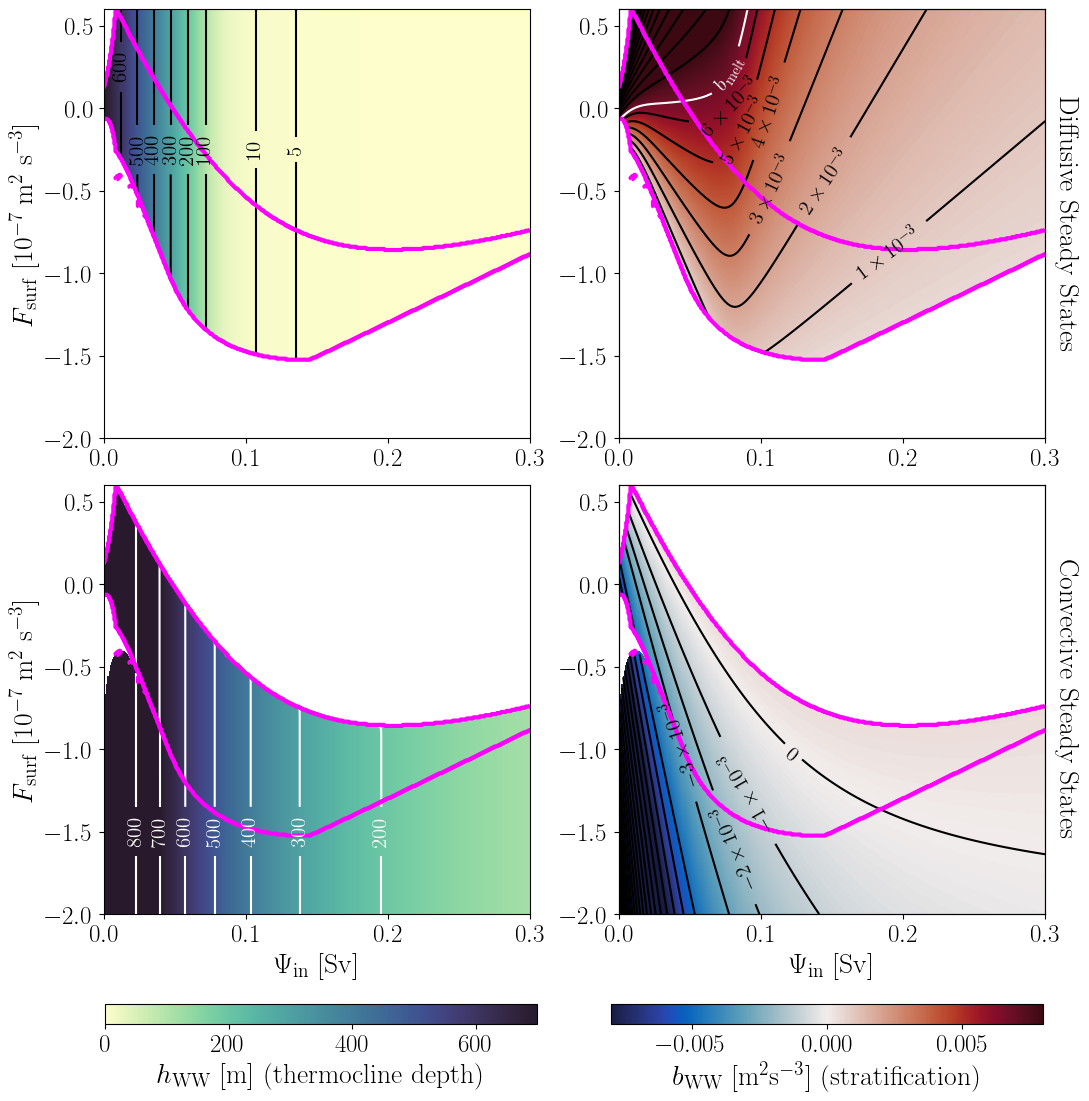

In [22]:
fig, ((ax,ax1),(ax2,ax3)) = plt.subplots(2, 2, figsize=(11,10))

ds = phase_space
f=20

REGIME = ds.REGIME.load()
h_diffusive = ds.h_diff.load()
h_convective = ds.h_conv.load()
b_diffusive = ds.b_diff.load()
b_convective = ds.b_conv.load()
translation = 1e6/(55*1e3)
Ψin = ds.Ψin.load()/translation ## conversion step!!
Fsurf = ds.Fsurf.load()


l1 = [5,10,100,200,300,400,500,600]
strs1 = [ r'$5$',r'$10$',r'$100$', r'$200$', r'$300$',r'$400$',r'$500$', '600']
manual_locations1 = [(0.15,-0.251),(0.12,-0.251),(0.08,-0.251),(0.07,-0.251),(0.06,-0.251),(0.05,-0.251),(0.03,-0.251),(0.01,0.251)]

l2 = np.arange(10,70,10)*1e-4
strs2 = [r'$1\times 10^{-3}$', r'$2\times 10^{-3}$', r'$3\times 10^{-3}$', r'$4\times 10^{-3}$', r'$5\times 10^{-3}$', r'$6\times 10^{-3}$']
manual_locations2 = [(0.2, -1), (0.17,-0.6 ), (0.11,-0.5 ), (0.1,0 ), (0.08,-0.1 ), (0.08,0 )]

c1=ax.pcolormesh(Ψin,Fsurf*1e7,h_diffusive, cmap=cm.deep, vmin=0,vmax=H)
labeled_contours(ax,h_diffusive,l1,strs1,manual_locations1, color='k',f=15)
c2=ax1.pcolormesh(Ψin,Fsurf*1e7 ,b_diffusive,cmap=cm.balance, vmin=-8*1e-3, vmax=8*1e-3)
labeled_contours(ax1,b_diffusive,l2,strs2,manual_locations2, color='k',f=15)
labeled_contours(ax1,b_diffusive,np.array([b_melt]),[r'$b_\mathrm{melt}$'],[(0.1,0.1)], color='w',f=15)
ax1.contour(Ψin,Fsurf*1e7 ,b_diffusive, levels=np.arange(80,300,10)*1e-4, colors=['k'])


###################   TMP     ###################
# ax.plot(Ψin_WAIS1080_clim,Fsurf_WAIS1080_clim*1e7, 'ko-',alpha=1, markersize=4 , label='WAIS1080 climatology');
###################   TMP     ###################


l1 = [200,300,400,500,600,700,800]
strs1 = [ r'$200$',r'$300$',r'$400$', r'$500$', r'$600$',r'$700$',r'$800$']
manual_locations1 = [(0.2,-1.5),(0.14,-1.5),(0.11,-1.5),(0.08,-1.5),(0.06,-1.5),(0.04,-1.5),(0.02,-1.5)]
l2 = np.arange(0,40,10)*1e-4
strs2 = [r'$0$', r'$-1\times 10^{-3}$', r'$-2\times 10^{-3}$', r'$-3\times 10^{-3}$']
manual_locations2 = [(0.15, -0.7), (0.1,-1.2 ), (0.08,-1.6 ), (0.03,-1 )]


c1=ax2.pcolormesh(Ψin,Fsurf*1e7 ,h_convective, cmap=cm.deep, vmin=0,vmax=H)
labeled_contours(ax2,h_convective,l1,strs1,manual_locations1, color='w',f=15)
c2=ax3.pcolormesh(Ψin,Fsurf*1e7 ,b_convective, cmap=cm.balance, vmin=-8*1e-3, vmax=8*1e-3)
labeled_contours(ax3,-b_convective,l2,strs2,manual_locations2, color='k',f=15)
ax3.contour(Ψin,Fsurf*1e7 ,-b_convective, levels=np.arange(50,300,10)*1e-4, colors=['k'])

ax.set_ylabel('$F_\mathrm{surf}\; [10^{-7} \;\mathrm{m}^{2}\;\mathrm{ s}^{-3}]$', fontsize=f)
ax2.set_ylabel('$F_\mathrm{surf}\; [10^{-7} \;\mathrm{m}^{2}\;\mathrm{ s}^{-3}]$', fontsize=f)
ax2.set_xlabel('$\Psi_\mathrm{in}\; [\mathrm{Sv}]$', fontsize=f)
ax3.set_xlabel('$\Psi_\mathrm{in}\; [\mathrm{Sv}]$', fontsize=f)
    
ax.contour(Ψin,Fsurf*1e7,REGIME.where(REGIME==3).fillna(0), levels=[0,3],colors='fuchsia',linewidths=3)
ax1.contour(Ψin,Fsurf*1e7,REGIME.where(REGIME==3).fillna(0), levels=[0,3],colors='fuchsia',linewidths=3)
ax2.contour(Ψin,Fsurf*1e7,REGIME.where(REGIME==3).fillna(0), levels=[0,3],colors='fuchsia',linewidths=3)
ax3.contour(Ψin,Fsurf*1e7,REGIME.where(REGIME==3).fillna(0), levels=[0,3],colors='fuchsia',linewidths=3)

# ax.axvline(κ_conv*L/H*1/translation,linestyle='dashed', linewidth=1, color='lightpink')
# ax1.axvline(κ_conv*L/H*1/translation,linestyle='dashed', linewidth=1, color='lightpink')
# ax2.axvline(κ_conv*L/H*1/translation,linestyle='dashed', linewidth=1, color='lightpink')
# ax3.axvline(κ_conv*L/H*1/translation,linestyle='dashed', linewidth=1, color='lightpink')


ax4 = ax1.twinx();ax5 = ax3.twinx();ax4.set_yticks([]);ax5.set_yticks([])
ax4.set_ylabel('Diffusive Steady States', rotation=-90,labelpad=25,fontsize=20)
ax5.set_ylabel('Convective Steady States', rotation=-90,labelpad=25,fontsize=20)

cax = fig.add_axes([0.1, -0.03, 0.393, 0.02])
cbar=plt.colorbar(c1,cax = cax,orientation='horizontal',shrink = 0.5)
cbar.set_label('$h_\mathrm{WW}\; [\mathrm{m}] $ (thermocline depth)', fontsize = f)
cax = fig.add_axes([0.56, -0.03, 0.393, 0.02])
cbar=plt.colorbar(c2,cax = cax,orientation='horizontal',shrink = 0.5)
cbar.set_label('$b_\mathrm{WW}\; [\mathrm{m}^{2}\mathrm{s}^{-3}] $ (stratification)', fontsize = f)

# ax.set_ylim([-2.3,0.6]);ax1.set_ylim([-2.3,0.6]);ax2.set_ylim([-2.3,0.6]);ax3.set_ylim([-2.3,0.6]);

fig.tight_layout()
# plt.savefig('Figure3_phase_diagram.png')

plt.show()

## How does this compare with our analytically derived solutions?

In [24]:
def analytical_hWW(Ψin, α, κP, H=700, L=5e4):
    hWW = H/2 - Ψin/(2*α)+np.sqrt((H/2 - Ψin/(2*α))**2+κP*L/(α))
    return hWW
def analytical_bWW(hWW, Ψin, α, κP, Fsurf, H=700, L=5e4, bmelt=0.0067):
    bWW = (hWW - Ψin/α)*(Fsurf*L/(2*Ψin)+bmelt)/(κP*L/(2*Ψin)+H/2-Ψin/α) - bmelt
    return bWW
def analytical_phase_space(Ψin_min,Ψin_max,Fsurf_min,Fsurf_max, n, params):
    L=params["L"];H = params["H"]; κ_diff = params["κ_diff"];κ_conv = params["κ_conv"];b_melt = params["b_melt"];b_crit = params["b_crit"];ϕ = params["ϕ"];α = params["α"];
    Ψin          = np.linspace(Ψin_min,Ψin_max,n)
    Fsurf        = np.linspace(Fsurf_min,Fsurf_max,n)
    Ψin_grid, Fsurf_grid = np.meshgrid(Ψin,Fsurf)
    hWW_diffusive = analytical_hWW(Ψin_grid, α, κP=κ_diff, H=700, L=5e4)
    bWW_diffusive = analytical_bWW(hWW_diffusive, Ψin_grid, α, κ_diff, Fsurf_grid, H=700, L=5e4, bmelt=0.0067)
    hWW_convective = analytical_hWW(Ψin_grid, α, κP=κ_conv, H=700, L=5e4)
    bWW_convective = analytical_bWW(hWW_convective, Ψin_grid, α, κ_conv, Fsurf_grid, H=700, L=5e4, bmelt=0.0067)
    bWW_diffusive = np.where(bWW_diffusive>b_crit,bWW_diffusive,np.nan)
    hWW_diffusive = hWW_diffusive*(bWW_diffusive*0+1)
    bWW_convective = np.where(bWW_convective<b_crit,bWW_convective,np.nan)
    hWW_convective = hWW_convective*(bWW_convective*0+1)
    return Ψin, Fsurf,hWW_diffusive,bWW_diffusive,hWW_convective,bWW_convective
def analytical_phase_space_plots(Ψin_min,Ψin_max,Fsurf_min,Fsurf_max, n, params):
    Ψin, Fsurf,hWW_diffusive,bWW_diffusive,hWW_convective,bWW_convective = analytical_phase_space(Ψin_min,Ψin_max,Fsurf_min,Fsurf_max, n, params)
    region_diff = hWW_diffusive*0+1
    region_conv = hWW_convective*0+1
    region = np.nan_to_num(region_diff*region_conv)
    
    fig, ((ax,ax1),(ax2,ax3)) = plt.subplots(2, 2, figsize=(11,10))
    translation = 1e6/(55*1e3)

    f=20
    h_levels = np.arange(0,900,100)
    b_levels = np.arange(-500,500,10)*1e-4

    c1=ax.pcolormesh(Ψin/translation,Fsurf*1e7,hWW_diffusive, cmap=cm.deep, vmin=0,vmax=H)
    ax.contour(Ψin/translation,Fsurf*1e7 ,hWW_diffusive, levels=h_levels, colors=['k'])
    ax.contour(Ψin/translation,Fsurf*1e7 ,hWW_diffusive, levels=[700], colors=['pink'])

    c2=ax1.pcolormesh(Ψin/translation,Fsurf*1e7 ,bWW_diffusive,cmap=cm.balance, vmin=-8*1e-3, vmax=8*1e-3)
    ax1.contour(Ψin/translation,Fsurf*1e7 ,bWW_diffusive, levels=b_levels, colors=['k'])
    ax1.contour(Ψin/translation,Fsurf*1e7 ,bWW_diffusive, levels=[b_melt], colors=['w'])

    ax2.pcolormesh(Ψin/translation,Fsurf*1e7,hWW_convective, cmap=cm.deep, vmin=0,vmax=H)
    ax2.contour(Ψin/translation,Fsurf*1e7 ,hWW_convective, levels=h_levels, colors=['w'])
    ax2.contour(Ψin/translation,Fsurf*1e7 ,hWW_convective, levels=[700], colors=['m'])

    ax3.pcolormesh(Ψin/translation,Fsurf*1e7 ,bWW_convective,cmap=cm.balance, vmin=-8*1e-3, vmax=8*1e-3)
    ax3.contour(Ψin/translation,Fsurf*1e7 ,bWW_convective, levels=b_levels, colors=['k'])


    ax4 = ax1.twinx();ax5 = ax3.twinx();ax4.set_yticks([]);ax5.set_yticks([])
    ax4.set_ylabel('Diffusive Steady States', rotation=-90,labelpad=25,fontsize=20)
    ax5.set_ylabel('Convective Steady States', rotation=-90,labelpad=25,fontsize=20)

    ax.contour(Ψin/translation,Fsurf*1e7,region, levels=[0,3],colors='fuchsia',linewidths=3)
    ax1.contour(Ψin/translation,Fsurf*1e7,region, levels=[0,3],colors='fuchsia',linewidths=3)
    ax2.contour(Ψin/translation,Fsurf*1e7,region, levels=[0,3],colors='fuchsia',linewidths=3)
    ax3.contour(Ψin/translation,Fsurf*1e7,region, levels=[0,3],colors='fuchsia',linewidths=3)


    cax = fig.add_axes([0.1, -0.03, 0.393, 0.02])
    cbar=plt.colorbar(c1,cax = cax,orientation='horizontal',shrink = 0.5)
    cbar.set_label('$h\; [\mathrm{m}] $ (thermocline depth)', fontsize = f)
    cax = fig.add_axes([0.56, -0.03, 0.393, 0.02])
    cbar=plt.colorbar(c2,cax = cax,orientation='horizontal',shrink = 0.5)
    cbar.set_label('$\Delta b\; [\mathrm{m}\mathrm{s}^{-2}] $ (stratification)', fontsize = f)

    ax.set_ylabel('$F_\mathrm{surf}\; [10^{-7} \;\mathrm{m}^{2}\;\mathrm{ s}^{-3}]$', fontsize=f)
    ax2.set_ylabel('$F_\mathrm{surf}\; [10^{-7} \;\mathrm{m}^{2}\;\mathrm{ s}^{-3}]$', fontsize=f)
    ax2.set_xlabel('$\Psi_\mathrm{in}\; [\mathrm{Sv}]$', fontsize=f)
    ax3.set_xlabel('$\Psi_\mathrm{in}\; [\mathrm{Sv}]$', fontsize=f)


    fig.tight_layout()
    plt.show()

In [25]:
params

{'L': 50000.0,
 'H': 700,
 'κ_diff': 0.0001,
 'κ_conv': 0.01,
 'b_melt': 0.0067,
 'b_crit': 0.0005,
 'ϕ': 50000.0,
 'α': 0.0021}

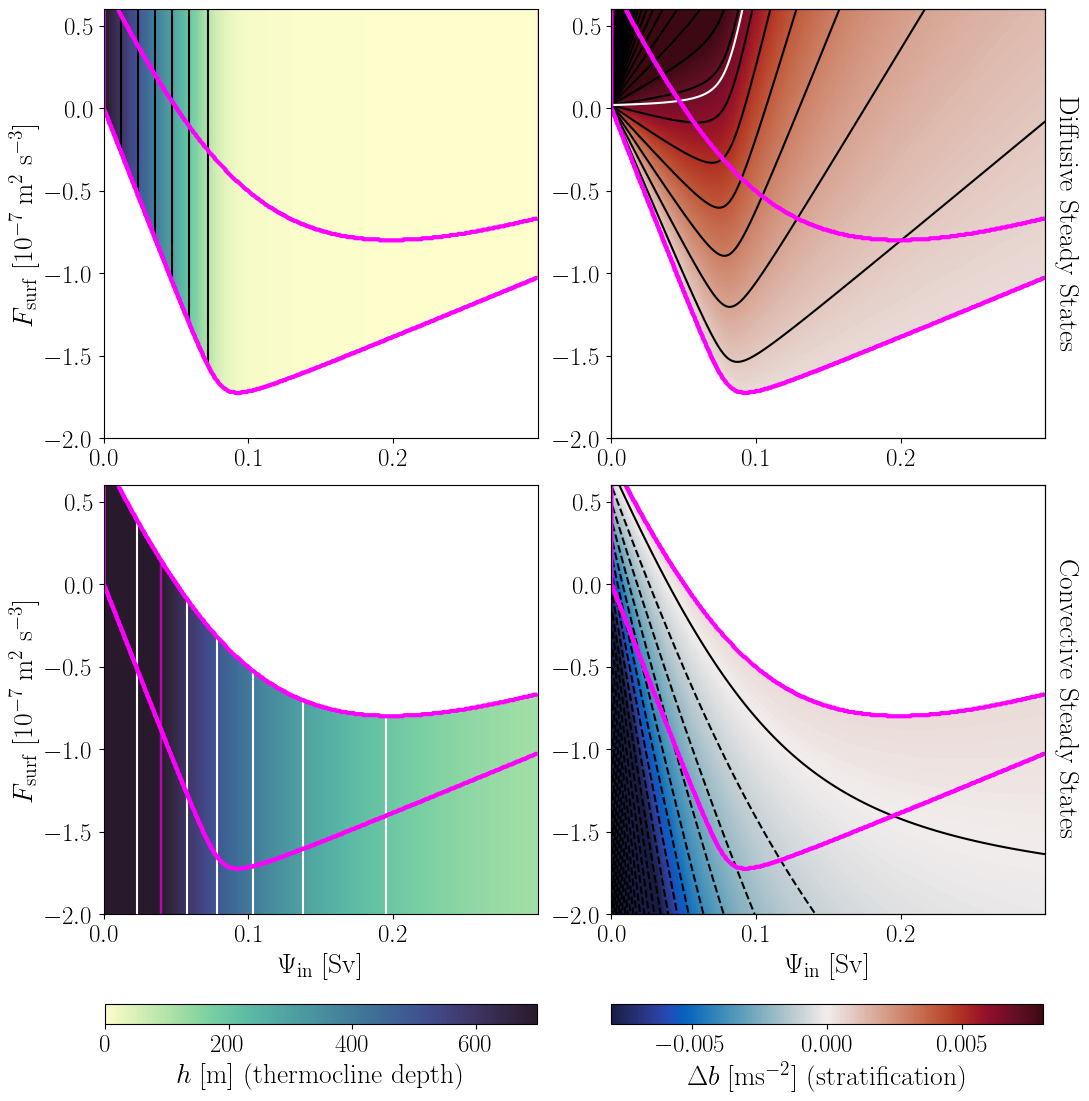

In [26]:
analytical_phase_space_plots(0, 5.45, -2e-7,6e-8, 400, params)

They are in agreement, the only different is a slightly contraction of the bistable region in the numerical solutions related to the transition between diffusivities being smoother than a pure step function.